<font color='turquoise'><font size='5'>**Workplace Project:** Forecasting the returns of a portfolio of 2 shares, taking into account their dependency structure</font>

<font color='turquoise'><font size='4'>**Introduction**</font>

In this notebook, we explore how to forecast the riskiness inherent from a portfolio constituting of two shares using a blend of statistical models and methods. We take into consideration the inherent patterns in each share data time series as well as the dependence structure between the two.

When it comes to predicting share prices, a blend of statistical techniques can help capture different aspects of market behavior. ARIMA (AutoRegressive Integrated Moving Average) models are great for capturing time series data's linear patterns and trends. They help predict future values based on past data, handling trends and seasonality.

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models extend this by focusing on volatility. They help in understanding and forecasting the fluctuating variance, making them crucial for financial data where volatility clustering is common.

Lastly, Copulas bring in the power of dependency structures, allowing us to model and simulate the joint distribution of multiple financial assets. This is key for portfolio management and risk assessment, where the relationships between assets need to be understood and modeled.

Combining these methods gives a robust framework for understanding and predicting share prices, capturing trends, volatility, and dependencies.

For the purpose of this project we are using data for Apple Inc. and Nvidia Corporation.

This notebook is structured as follows:
* Importing the required packages
* Importing and filtering the data
* Exploratory Data Analysis (EDA) and Cleaning
* Further Analysis and Visualisations
* Modeling and forecasting
* Conclusion
* References


<font color='turquoise'><font size='4'>**Importing the required packages**</font>

Let's begin by importing the required Python packages.


In [1]:
# Import sktime and all its dependencies first
!pip install sktime[all_extras]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.0/851.0 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [21]:
# Import the rest of the packages
# The import process has been split into 2 as importing sktime and all its dependencies is time consuming
import pandas as pd # Importing the numpy package with an alias, np
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import yfinance as yf
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from arch import arch_model
import seaborn as sns
sns.set_theme(style="darkgrid") # Set the seaborn colour theme

Export the current environment for reproduceability.

In [3]:
# Export the packages/requirements
!pip freeze > requirements.txt

<font color='turquoise'><font size='4'>**Importing and filtering the data**</font>

<font size='4'>**Importing the data**</font>


We can then proceed with importing the data from yahoo finance using the yfinance package. For the purpose of this project we are using data for Apple Inc. and Nvidia Corporation which are both quoted on the NASDAQ stock exchange and with tickers 'AAPL' and 'NVDA' respectively.

Both companies operate in the technology field and intuitively, we expect that they should be influenced by similar factors.

For instance, rise in the price of raw materials such as copper which are important in circuitry, changes in regulations for technology and so on. Bearing this in mind, we already expect some degree of positive dependence between the two.

In [4]:
# Download stock data for NVIDIA and Apple (Both "daily" as specfied by the interval)
data = yf.download(['NVDA', 'AAPL'], start='2000-01-01', end='2024-10-14', interval='1d')

# Display the first few rows of the initial DataFrame
data.head()

[*********************100%***********************]  2 of 2 completed


Price                     Adj Close               Close                High  \
Ticker                         AAPL      NVDA      AAPL      NVDA      AAPL   
Date                                                                          
2000-01-03 00:00:00+00:00  0.844004  0.089446  0.999442  0.097526  1.004464   
2000-01-04 00:00:00+00:00  0.772846  0.087058  0.915179  0.094922  0.987723   
2000-01-05 00:00:00+00:00  0.784155  0.084191  0.928571  0.091797  0.987165   
2000-01-06 00:00:00+00:00  0.716296  0.078698  0.848214  0.085807  0.955357   
2000-01-07 00:00:00+00:00  0.750226  0.080012  0.888393  0.087240  0.901786   

Price                                     Low                Open            \
Ticker                         NVDA      AAPL      NVDA      AAPL      NVDA   
Date                                                                          
2000-01-03 00:00:00+00:00  0.099219  0.907924  0.091927  0.936384  0.098438   
2000-01-04 00:00:00+00:00  0.096094  0.903460  0.090104  0.966518  0.095833   
2000-01-05 00:00:00+00:00  0.093750  0.919643  0.090495  0.926339  0.092188   
2000-01-06 00:00:00+00:00  0.091797  0.848214  0.082292  0.947545  0.091797   
2000-01-07 00:00:00+00:00  0.088151  0.852679  0.084115  0.861607  0.085417   

Price                         Volume             
Ticker                          AAPL       NVDA  
Date                                             
2000-01-03 00:00:00+00:00  535796800  300912000  
2000-01-04 00:00:00+00:00  512377600  300480000  
2000-01-05 00:00:00+00:00  778321600  188352000  
2000-01-06 00:00:00+00:00  767972800  120480000  
2000-01-07 00:00:00+00:00  460734400   71184000

In [5]:
# Display the last few rows of the initial DataFrame
data.tail()

Price                       Adj Close                   Close              \
Ticker                           AAPL        NVDA        AAPL        NVDA   
Date                                                                        
2024-10-07 00:00:00+00:00  221.690002  127.720001  221.690002  127.720001   
2024-10-08 00:00:00+00:00  225.770004  132.889999  225.770004  132.889999   
2024-10-09 00:00:00+00:00  229.539993  132.649994  229.539993  132.649994   
2024-10-10 00:00:00+00:00  229.039993  134.809998  229.039993  134.809998   
2024-10-11 00:00:00+00:00  227.550003  134.800003  227.550003  134.800003   

Price                            High                     Low              \
Ticker                           AAPL        NVDA        AAPL        NVDA   
Date                                                                        
2024-10-07 00:00:00+00:00  225.690002  130.639999  221.330002  124.949997   
2024-10-08 00:00:00+00:00  225.979996  133.479996  223.250000  129.419998   
2024-10-09 00:00:00+00:00  229.750000  134.520004  224.830002  131.380005   
2024-10-10 00:00:00+00:00  229.500000  135.000000  227.169998  131.000000   
2024-10-11 00:00:00+00:00  229.410004  135.779999  227.339996  133.660004   

Price                            Open                Volume             
Ticker                           AAPL        NVDA      AAPL       NVDA  
Date                                                                    
2024-10-07 00:00:00+00:00  224.500000  124.989998  39505400  346250200  
2024-10-08 00:00:00+00:00  224.300003  130.259995  31855700  285722500  
2024-10-09 00:00:00+00:00  225.229996  134.110001  33591100  246191600  
2024-10-10 00:00:00+00:00  227.779999  131.910004  28183500  242311300  
2024-10-11 00:00:00+00:00  229.300003  134.009995  31759200  170209500

The data consists of:
* <i>Date</i> which is the trading date.
* <i>Adj Close</i> and <i>Close </i> both represent the final price at which a share is traded at the end of a trading day. <i>Adj Close</i> (Adjusted Close) however adjusts the closing price to reflect events like dividends, stock splits, and new offerings.
* <i> High </i> and <i> Low </i> are the highest and lowest prices the shares have reached that particular trading day.
* <i>Opening</i> represents the opening price at which a share is traded at the end of a trading day.
* <i>Volume</i> refers to the number of shares traded over that particular trading day.
Except for <i>Date</i>, each of the data fields is available for each of Apple and Nvidia.

For the purpose of our analysis, we will be using <i>Close </i>.











<font size='4'>**Filtering the data**</font>

Let us first proceed with visualising the data. Below is depicted the price evolution, across time, of the two shares.

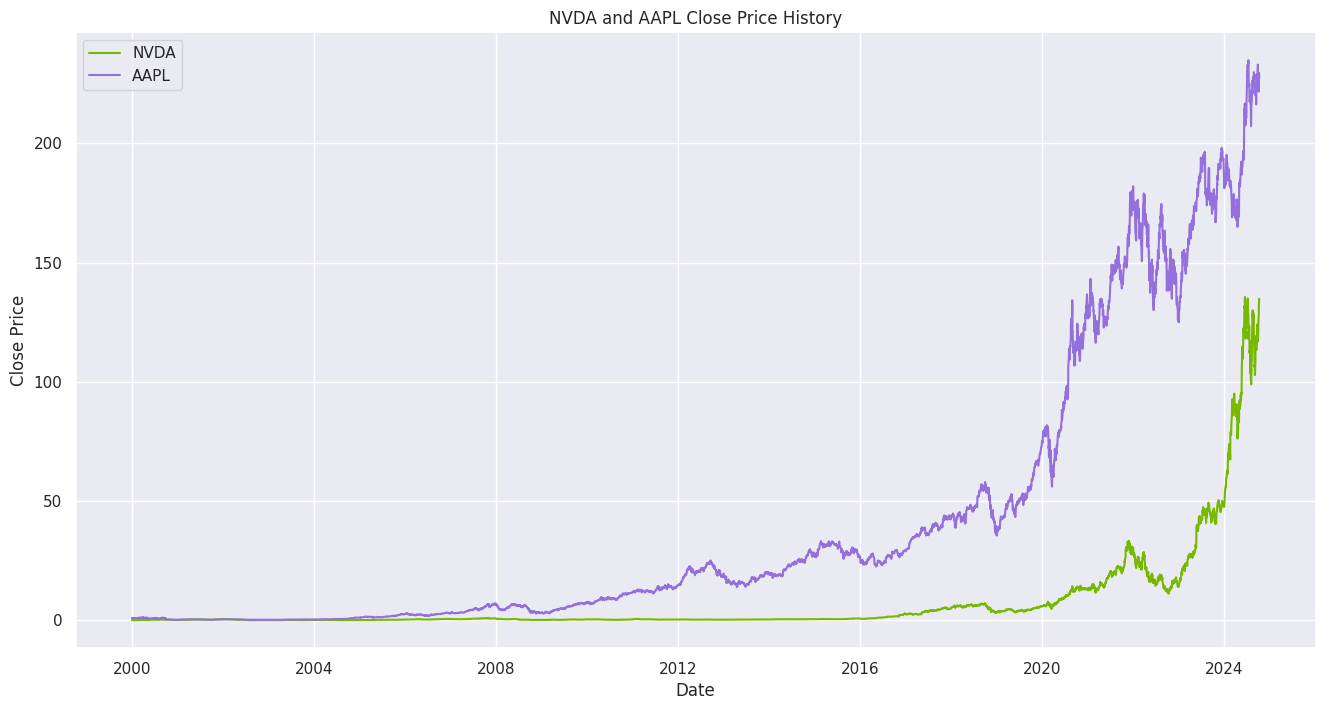

In [6]:
# Plot the close price history

# Define colours for ease of reference
# NVDA green logo color (approx)
nvda_logo_color = '#76B900'
# Bright purple color for Apple
aapl_bright_color = 'mediumpurple'


plt.figure(figsize=(16, 8))

# Plot NVDA Close Price history
plt.plot(data.index, data['Close']['NVDA'], label='NVDA', color= nvda_logo_color)

# Plot AAPL Close Price history
plt.plot(data.index, data['Close']['AAPL'], label='AAPL', color= aapl_bright_color)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('NVDA and AAPL Close Price History')
plt.legend()
plt.grid(True)
plt.show()

The graph shows that the growth of Apple's share price is somewhat linear over the around 2009 to 2015 before it grows at a more exponential rate.

For Nvidia this exponential growth is seen as from around 2021.

A few need to be considered before proceeding further:
* The data includes extreme events happening such as the dot-com bubble crisis which peaked in March 2020, the great financial crisis which occured in 2007-2008 and the more recent covid pandemic period.
* Using data which is too far back in the past might not to be relevant for forecasting as trends might have changed; there is always the questions of: "how much data is sufficient and how much is too much?". These questions are particularly relevant for technology companies where the rate of change in the operating environment is very fast and recent growth has been massive.

As such, we will use data spanning from start of 2015 to mid October 2024, roughly 10 years of data for analysis which should be sufficient but also not too far back.

In [7]:
# Ensure Date is a column
data.reset_index(inplace=True)

# Filter based on dates
mask = (data['Date'] >= '2015-01-01') & (data['Date'] <= '2024-10-15')
filtered_data = data.loc[mask].copy()

# Display the filtered DataFrame
filtered_data.head()

Price                       Date  Adj Close                Close           \
Ticker                                 AAPL      NVDA       AAPL     NVDA   
3773   2015-01-02 00:00:00+00:00  24.373960  0.483177  27.332500  0.50325   
3774   2015-01-05 00:00:00+00:00  23.687307  0.475016  26.562500  0.49475   
3775   2015-01-06 00:00:00+00:00  23.689533  0.460614  26.565001  0.47975   
3776   2015-01-07 00:00:00+00:00  24.021708  0.459414  26.937500  0.47850   
3777   2015-01-08 00:00:00+00:00  24.944681  0.476696  27.972500  0.49650   

Price        High                 Low                Open              Volume  \
Ticker       AAPL     NVDA       AAPL     NVDA       AAPL     NVDA       AAPL   
3773    27.860001  0.50700  26.837500  0.49525  27.847500  0.50325  212818400   
3774    27.162500  0.50475  26.352501  0.49250  27.072500  0.50325  257142000   
3775    26.857500  0.49600  26.157499  0.47925  26.635000  0.49550  263188400   
3776    27.049999  0.48750  26.674999  0.47700  26.799999  0.48325  160423600   
3777    28.037500  0.49950  27.174999  0.48375  27.307501  0.48400  237458000   

Price              
Ticker       NVDA  
3773    113680000  
3774    197952000  
3775    197764000  
3776    321808000  
3777    283780000

<font size='4'>**Creating log returns**</font>

To implement the ARIMA and GARCH models, we calculate the log returns (log to base <i>e </i>) of the data. These are more statistically robust than simple returns. They help in stabilising the variance and normalising the data, making the time series more suitable for model assumptions. This helps ARIMA capture linear relationships and trends more effectively, while GARCH can more accurately model volatility clustering.

**To note that this step has been implemented before the data cleanup as we would also like to investigate any abnormally large values in the log returns.**

In [8]:
# Calculate log returns
filtered_data['NVDA_log_return'] = np.log(filtered_data['Close']['NVDA'] / filtered_data['Close']['NVDA'].shift(1))
filtered_data['AAPL_log_return'] = np.log(filtered_data['Close']['AAPL'] / filtered_data['Close']['AAPL'].shift(1))

# Drop the first row as first value of log returns will be NaN
filtered_data = filtered_data.drop(filtered_data.index[0])

# Display the DataFrame with log returns
print(filtered_data.head())

Price                       Date  Adj Close                Close           \
Ticker                                 AAPL      NVDA       AAPL     NVDA   
3774   2015-01-05 00:00:00+00:00  23.687307  0.475016  26.562500  0.49475   
3775   2015-01-06 00:00:00+00:00  23.689533  0.460614  26.565001  0.47975   
3776   2015-01-07 00:00:00+00:00  24.021708  0.459414  26.937500  0.47850   
3777   2015-01-08 00:00:00+00:00  24.944681  0.476696  27.972500  0.49650   
3778   2015-01-09 00:00:00+00:00  24.971439  0.478616  28.002501  0.49850   

Price        High                 Low                Open              Volume  \
Ticker       AAPL     NVDA       AAPL     NVDA       AAPL     NVDA       AAPL   
3774    27.162500  0.50475  26.352501  0.49250  27.072500  0.50325  257142000   
3775    26.857500  0.49600  26.157499  0.47925  26.635000  0.49550  263188400   
3776    27.049999  0.48750  26.674999  0.47700  26.799999  0.48325  160423600   
3777    28.037500  0.49950  27.174999  0.48375  27.3075

<font color='turquoise'><font size='4'>**Exploratory Data Analysis (EDA) and Cleaning**</font>

<font size='4'>**Data Cleaning**</font>

The data is exported to excel for more in depth data checks.

In [9]:
# Export to Excel
# Convert 'Date' column to timezone-naive datetime objects which excel supports
filtered_data_v2 = filtered_data.copy()
filtered_data_v2['Date'] = filtered_data['Date'].dt.tz_localize(None)

#Now export the updated DataFrame
filtered_data_v2.to_excel('data.xlsx', index=True)

A battery of checks were performed in excel. The main issue found was that the data was missing 22 trading days which was not explainable. This was after excluding weekends and public holidays (where no trading is expected). Given that this number is (1) low compared to the overall number of data points (less than 1%) and (2) that they are not consecutive, decision has been taken to ignore this error as it is deemed to have little material impact.

<font size='4'>**Exploratory Data Analysis (EDA)**</font>

We start by checking the summary statistics of the data.

In [10]:
filtered_data.describe()

Price     Adj Close                     Close                      High  \
Ticker         AAPL         NVDA         AAPL         NVDA         AAPL   
count   2460.000000  2460.000000  2460.000000  2460.000000  2460.000000   
mean      91.219498    18.144857    93.243979    18.173908    94.168172   
std       62.911398    27.301164    62.430512    27.295433    63.038404   
min       20.720036     0.459414    22.584999     0.478500    22.917500   
25%       34.834349     3.419736    37.153124     3.454938    37.310625   
50%       61.866173     6.273192    63.637499     6.319875    64.505001   
75%      148.206978    19.868966   150.025002    19.903313   151.367504   
max      234.548523   135.568405   234.820007   135.580002   237.229996   

Price                        Low                      Open               \
Ticker         NVDA         AAPL         NVDA         AAPL         NVDA   
count   2460.000000  2460.000000  2460.000000  2460.000000  2460.000000   
mean      18.509013    92.229024    17.801809    93.170015    18.167258   
std       27.832313    61.754922    26.700407    62.378978    27.300838   
min        0.487500    22.367500     0.473500    22.500000     0.481250   
25%        3.520250    36.671875     3.386250    37.026249     3.430750   
50%        6.405375    62.145000     6.224500    62.706249     6.315375   
75%       20.178000   148.177498    19.464749   149.712502    19.888125   
max      140.759995   233.089996   133.660004   236.479996   139.800003   

Price         Volume               NVDA_log_return AAPL_log_return  
Ticker          AAPL          NVDA                                  
count   2.460000e+03  2.460000e+03     2460.000000     2460.000000  
mean    1.186624e+08  4.734196e+08        0.002273        0.000862  
std     6.822781e+07  2.533862e+08        0.030517        0.018074  
min     2.404830e+07  5.244800e+07       -0.207712       -0.137708  
25%     7.340735e+07  3.120010e+08       -0.012479       -0.007523  
50%     1.017478e+08  4.215930e+08        0.002630        0.000895  
75%     1.433835e+08  5.675970e+08        0.017453        0.010073  
max     6.488252e+08  3.692928e+09        0.260876        0.113157

Observations:
* The maximum and minimum log returns for each share price are also reasonable. To note that for AAPL, the maximum/minimum returns happened during the period where the covid pandemic was still ongoing, which might suggest there was higher volatility in share prices then. For NVDA, the maximum return was in  November 2016 which coincided with: "record revenue, record margins and record earnings were driven by strength across all product lines". The minimum return coincides with the period where share price plunged as the demand for GPUs (Graphical Processing Units, one of NVDA's main products) fell. These were used to mine crypto-currencies and when the value of these fell in 2018, so did the demand for GPUs.

**To note that the dates for same were derived in the accompanying excel workbook which contains the checks made.**

* The mean log returns were around zero.

We now proceed with comparing the log returns with white noise data to see if it exhibits volatility clustering; prolonged periods where the returns fluctuate a lot and prolonged periods where this is little fluctuation.

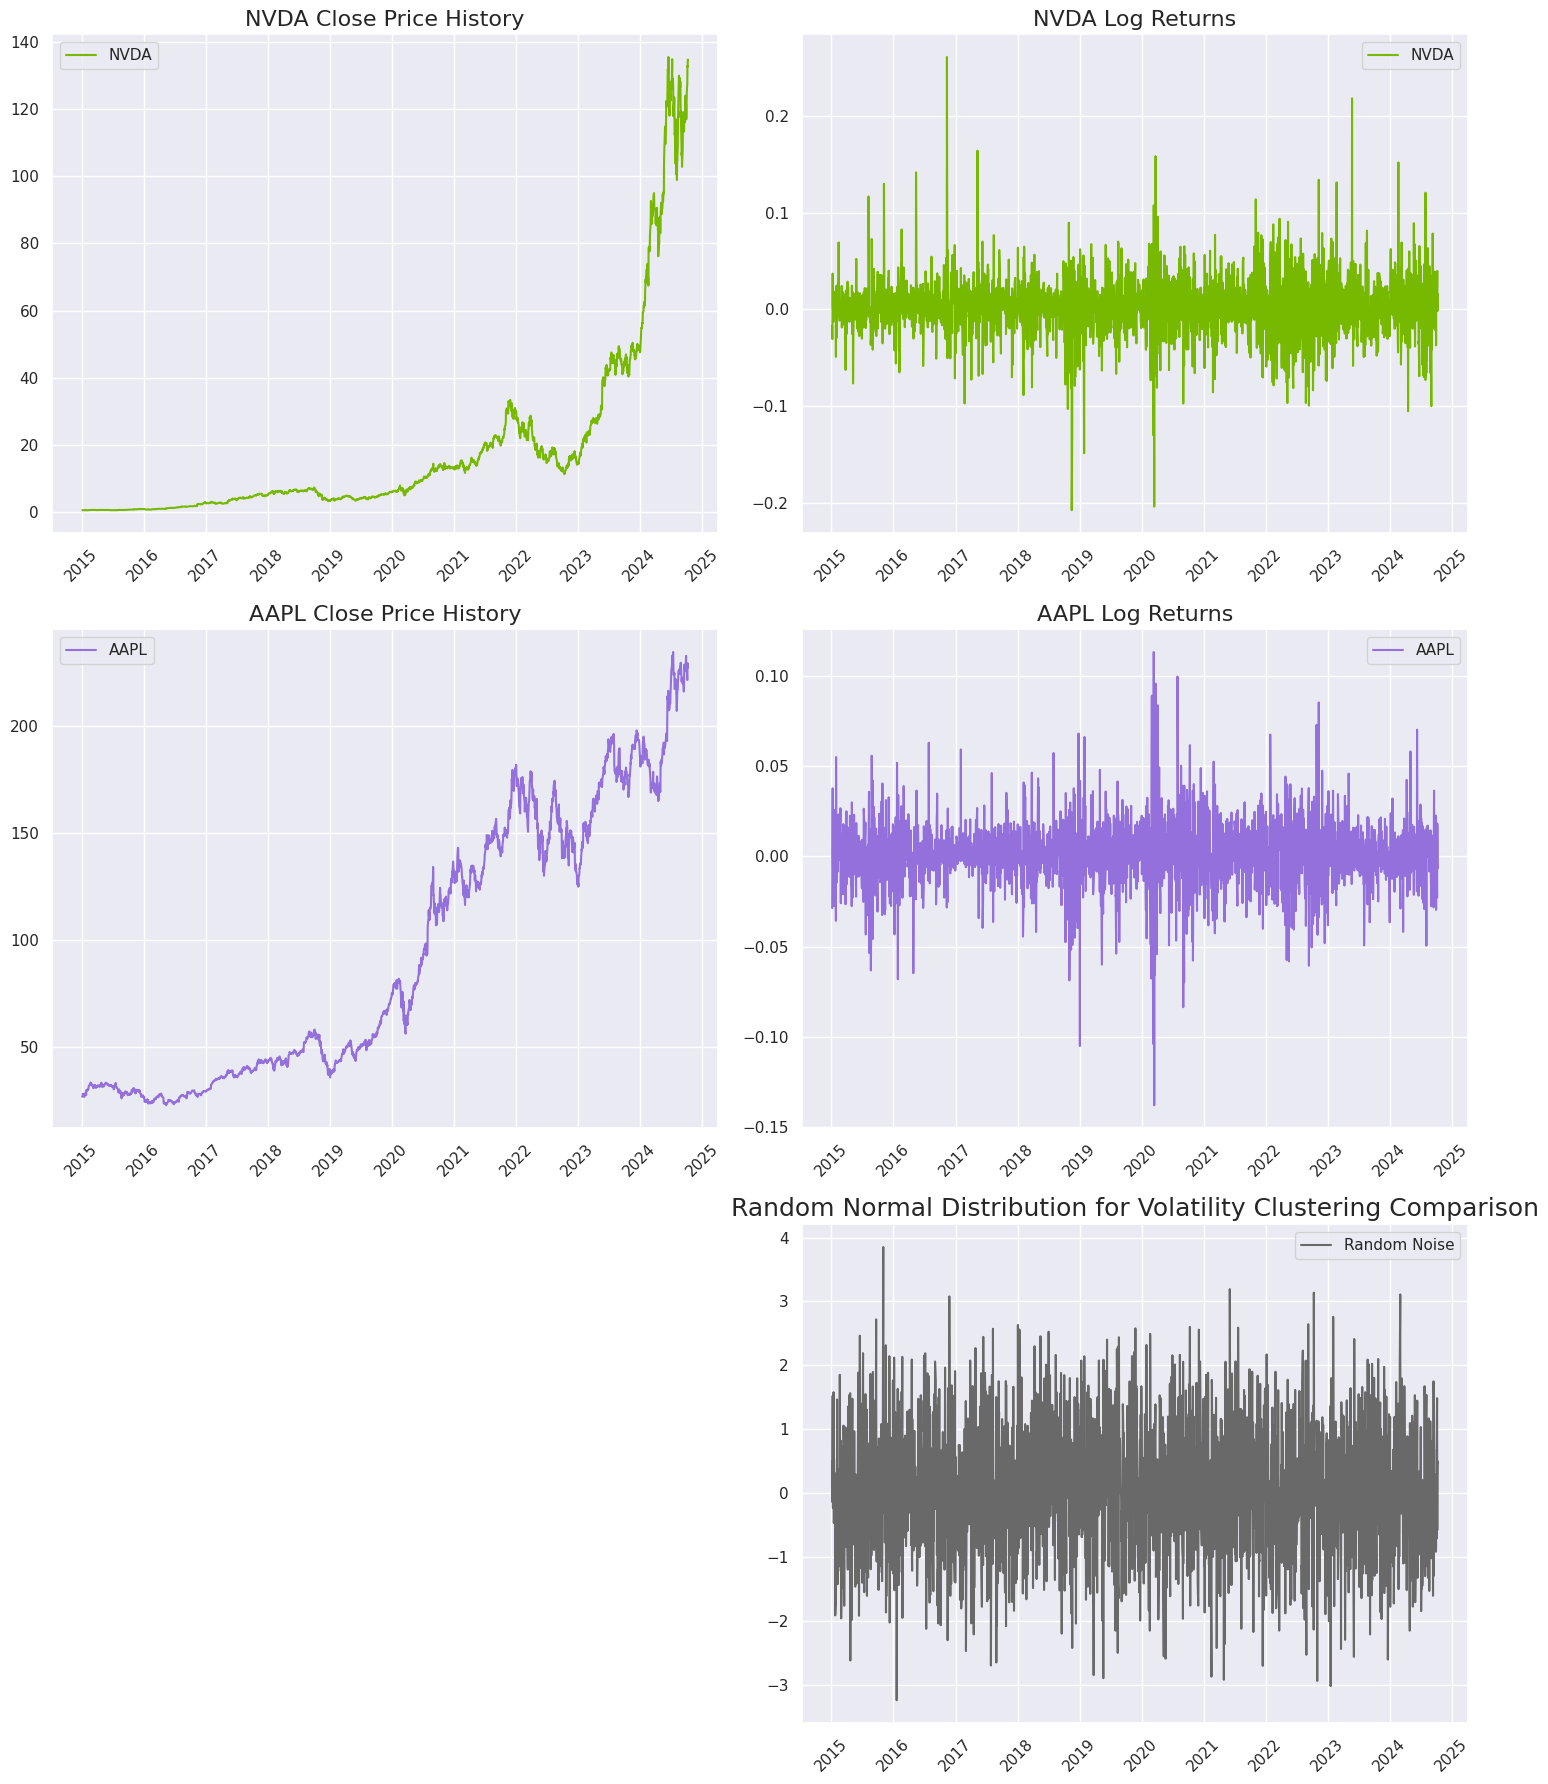

In [22]:
# Create subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 18))

# NVDA Close Price history
ax[0, 0].plot(filtered_data['Date'], filtered_data['Close']['NVDA'], label='NVDA', color= nvda_logo_color)
ax[0, 0].set_title('NVDA Close Price History', size=16)
ax[0, 0].legend()
ax[0, 0].tick_params(axis='x', rotation=45)

# NVDA log returns
ax[0, 1].plot(filtered_data['Date'], filtered_data['NVDA_log_return'], label='NVDA', color= nvda_logo_color)
ax[0, 1].set_title('NVDA Log Returns', size=16)
ax[0, 1].legend()
ax[0, 1].tick_params(axis='x', rotation=45)

# AAPL Close Price history
ax[1, 0].plot(filtered_data['Date'], filtered_data['Close']['AAPL'], label='AAPL', color=aapl_bright_color)
ax[1, 0].set_title('AAPL Close Price History', size=16)
ax[1, 0].legend()
ax[1, 0].tick_params(axis='x', rotation=45)

# AAPL log returns
ax[1, 1].plot(filtered_data['Date'], filtered_data['AAPL_log_return'], label='AAPL', color=aapl_bright_color)
ax[1, 1].set_title('AAPL Log Returns', size=16)
ax[1, 1].legend()
ax[1, 1].tick_params(axis='x', rotation=45)

# Add random normal distribution (white noise)
# Setting the seed for reproducibility
np.random.seed(42)
random_noise = np.random.normal(0, 1, len(filtered_data))
ax[2, 1].plot(filtered_data['Date'], random_noise, label='Random Noise', color='dimgray')
ax[2, 1].set_title('Random Normal Distribution for Volatility Clustering Comparison',size=18)
ax[2, 1].legend()
ax[2, 1].tick_params(axis='x', rotation=45)

# Hide empty subplot
fig.delaxes(ax[2,0])
plt.tight_layout()

plt.show()

The data shows volatility clustering; in 2020, both AAPL and NVDA had higher fluctuations in their log returns.

For the random noise series, there is no discernable pattern. This shows that the log returns would be a suitable candidate for GARCH models.

We then move on to KDE and pairwise correlation plots for the data.



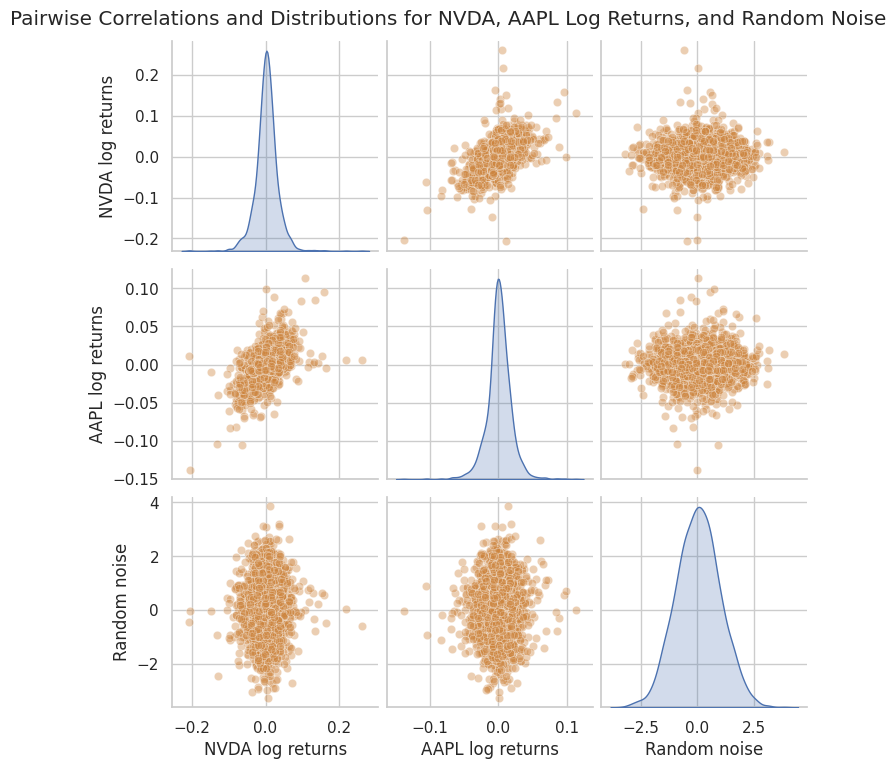

In [15]:
# Set theme for better visuals
sns.set_theme(style="whitegrid")

# Construct DataFrame with the relevant columns
data_kde = pd.DataFrame({
    'NVDA log returns': filtered_data['NVDA_log_return'],
    'AAPL log returns': filtered_data['AAPL_log_return'],
    'Random noise': random_noise
})

# Construct DataFrame with the relevant columns
data_kde = pd.DataFrame({
    'NVDA log returns': filtered_data['NVDA_log_return'],
    'AAPL log returns': filtered_data['AAPL_log_return'],
    'Random noise': random_noise
})

# Pairplot including histograms
g = sns.pairplot(data_kde, diag_kind='kde',plot_kws={'color': 'peru', "alpha":0.4})
plt.suptitle('Pairwise Correlations and Distributions for NVDA, AAPL Log Returns, and Random Noise', y=1.02)
plt.show()
plt.show()




We observe:
* The density functions for the share data are leptokurtic, i.e., they have fatter tails than the normal distribution. This shows that more extreme values have a higher probability of occuring than what the normal distibution would suggest. GARCH models are designed to capture this behaviour.
* The share log returns also show some positive correlation with each other. Each however has a low correlation (close to zero) with the Random noise.
This shows the importance of factoring the dependence between the two. Hence the use of copulas is essential.

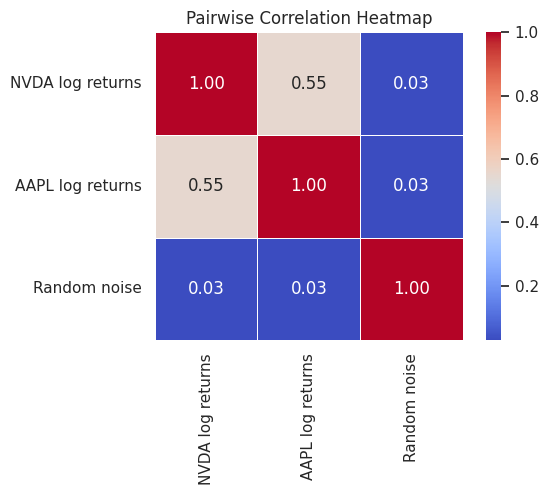

In [23]:
# Compute the correlation matrix
correlation_matrix = data_kde.corr()

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)

plt.title('Pairwise Correlation Heatmap')
plt.show()


The above correlation reinforces the view of positive correlation between the share data.

In [24]:
# Calculate kurtosis for each series
nvda_kurtosis = stats.kurtosis(data_kde['NVDA log returns'])
aapl_kurtosis = stats.kurtosis(data_kde['AAPL log returns'])
random_noise_kurtosis = stats.kurtosis(data_kde['Random noise'])

print("Kurtosis for NVDA log returns:", nvda_kurtosis)
print("Kurtosis for AAPL log returns:", aapl_kurtosis)
print("Kurtosis for Random noise:", random_noise_kurtosis)


Kurtosis for NVDA log returns: 6.828802326198751
Kurtosis for AAPL log returns: 5.359945612024626
Kurtosis for Random noise: 0.037833902189561286


The kurtosis of each share log returns is well above that of the random noise showing the presence of fat tails.

<font color='turquoise'><font size='4'>**References**</font>

**Excel formulae references**
* https://computing.net/office/how-to-find-the-last-monday-of-the-month-in-excel/#:~:text=The%20EOMONTH%20function%20is%20a,latest%20day%20of%20a%20month.
* https://www.statology.org/excel-first-monday-of-month/

**Research on share prices/news**
* https://www.fool.com/investing/2016/12/09/why-nvidia-corporation-stock-skyrocketed-296-in-no.aspx
* https://www.oyez.org/cases/2024/23-970#:~:text=However%2C%20the%20company's%20executives%2C%20particularly,did%20so%20knowingly%20or%20recklessly.

**GARCH literature**
*  Engle, R. and Mezrich, J. (1996). GARCH for Groups. Risk, 9(8), pp.36-40.
*  Engle, R. and Patton, A. (2001). What good is a volatility model?. Quantitative
 Finance, 1(2), pp.237-245.

**Copula/Dependence Structure literature**
* Nelsen, R. (1999). An introduction to copulas. New York: Springer
*  McNeil, A., Frey, R. and Embrechts, P. (2005). Quantitative risk management.
 Princeton, N.J. : Princeton University Press.
